In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [ ]:
"""
Remember to change model name, shape, fen_to_vector, dataloader
"""
RUN_ID = "run_2025_12_28_giraffe_baseline"

In [4]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        return self.X[idx], self.y[idx]

In [5]:
BATCH_SIZE = 2048
num_workers = 0

train_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed_clean_split/chess_state_bitboard_train.npz"), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed_clean_split/chess_state_bitboard_val.npz"), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed_clean_split/chess_state_bitboard_test.npz"), 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [6]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.020311832427978516


In [7]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([2048, 768]) dtype: torch.float32
y batch shape: torch.Size([2048]) dtype: torch.int64 classes in batch: [0, 1, 2, 3, 4, 5, 6]


In [8]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [9]:
class GiraffeBaseline(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.network(x)

In [10]:
from torchinfo import summary

model = GiraffeBaseline(input_shape=768,
                        hidden_units=2048,
                        output_shape=7) # 7 classes

summary(model, input_size=(2048, 768))

Layer (type:depth-idx)                   Output Shape              Param #
GiraffeBaseline                          [2048, 7]                 --
├─Sequential: 1-1                        [2048, 7]                 --
│    └─Linear: 2-1                       [2048, 2048]              1,574,912
│    └─ReLU: 2-2                         [2048, 2048]              --
│    └─Linear: 2-3                       [2048, 2048]              4,196,352
│    └─ReLU: 2-4                         [2048, 2048]              --
│    └─Linear: 2-5                       [2048, 7]                 14,343
Total params: 5,785,607
Trainable params: 5,785,607
Non-trainable params: 0
Total mult-adds (G): 11.85
Input size (MB): 6.29
Forward/backward pass size (MB): 67.22
Params size (MB): 23.14
Estimated Total Size (MB): 96.66

In [11]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [12]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """

    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [13]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   epochs: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_loss = float("inf")
    best_model_weights = None
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch}: New Best Val Loss: {val_loss:.4f} (Saved)")
            torch.save(model.state_dict(), f"{model_save_name}.pth")
        else:
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc: {train_acc} | Val Loss: {val_loss} | Val Acc: {val_acc}")

        # To plot results later
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Loss: {best_val_loss:.4f}")

    return results

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = GiraffeBaseline(input_shape=768,
                                   hidden_units=2048,
                                   output_shape=7).to(device)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

result = run_experiment(model=model,
                        model_save_name="giraffe_baseline_with_dropout_with_state",
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

  1%|          | 1/100 [00:14<24:13, 14.68s/it]

Epoch 0: New Best Val Loss: 1.3945 (Saved)
Epoch: 0 | Train Loss: 0.8914992630939045 | Train Acc: 0.6725006493765985 | Val Loss: 1.3945384804083376 | Val Acc: 0.5430144382340201


  2%|▏         | 2/100 [00:30<24:53, 15.24s/it]

Epoch 1: Train Loss: 0.4805 | Val Loss: 1.6772
Epoch: 1 | Train Loss: 0.48047787370279316 | Train Acc: 0.8251021519341433 | Val Loss: 1.6771559763927848 | Val Acc: 0.537182137743069


  3%|▎         | 3/100 [00:45<24:33, 15.19s/it]

Epoch 2: Train Loss: 0.3364 | Val Loss: 1.9602
Epoch: 2 | Train Loss: 0.3363544075842709 | Train Acc: 0.8788413123401535 | Val Loss: 1.9602405660006466 | Val Acc: 0.533397346998941


  4%|▍         | 4/100 [01:00<23:54, 14.94s/it]

Epoch 3: Train Loss: 0.2650 | Val Loss: 2.1703
Epoch: 3 | Train Loss: 0.26501842037491175 | Train Acc: 0.9047409486892583 | Val Loss: 2.170275972813976 | Val Acc: 0.5255641650823065


  5%|▌         | 5/100 [01:15<23:46, 15.01s/it]

Epoch 4: Train Loss: 0.2208 | Val Loss: 2.3993
Epoch: 4 | Train Loss: 0.22084299655978942 | Train Acc: 0.9199133831521739 | Val Loss: 2.3993409117873834 | Val Acc: 0.5229010862894686


  6%|▌         | 6/100 [01:30<23:38, 15.09s/it]

Epoch 5: Train Loss: 0.1881 | Val Loss: 2.6607
Epoch: 5 | Train Loss: 0.1880671637671073 | Train Acc: 0.9311925551470588 | Val Loss: 2.6607239757265364 | Val Acc: 0.5287574530106853


  7%|▋         | 7/100 [01:42<21:45, 14.04s/it]

Epoch 6: Train Loss: 0.1647 | Val Loss: 2.8073
Epoch: 6 | Train Loss: 0.16467961379329263 | Train Acc: 0.9395984854539642 | Val Loss: 2.807285250449667 | Val Acc: 0.5170685977810935


  8%|▊         | 8/100 [01:52<19:39, 12.82s/it]

Epoch 7: Train Loss: 0.1447 | Val Loss: 3.0907
Epoch: 7 | Train Loss: 0.14469378773132555 | Train Acc: 0.9467653552589514 | Val Loss: 3.090663399015154 | Val Acc: 0.5237227224321332


  9%|▉         | 9/100 [02:02<18:20, 12.10s/it]

Epoch 8: Train Loss: 0.1292 | Val Loss: 3.2753
Epoch: 8 | Train Loss: 0.12917513716632448 | Train Acc: 0.952737122362532 | Val Loss: 3.2753071152434057 | Val Acc: 0.5157915834376203


 10%|█         | 10/100 [02:13<17:20, 11.56s/it]

Epoch 9: Train Loss: 0.1172 | Val Loss: 3.5893
Epoch: 9 | Train Loss: 0.11721838822069071 | Train Acc: 0.9570080222985934 | Val Loss: 3.5893252869041596 | Val Acc: 0.5291573660714286


 11%|█         | 11/100 [02:23<16:33, 11.17s/it]

Epoch 10: Train Loss: 0.1061 | Val Loss: 3.6267
Epoch: 10 | Train Loss: 0.10607776891849839 | Train Acc: 0.9614427649456522 | Val Loss: 3.6266996909161002 | Val Acc: 0.5172470263164228


 12%|█▏        | 12/100 [02:34<16:03, 10.95s/it]

Epoch 11: Train Loss: 0.0969 | Val Loss: 3.9304
Epoch: 11 | Train Loss: 0.09689197570199856 | Train Acc: 0.9646659207161125 | Val Loss: 3.930369742062627 | Val Acc: 0.519081324304486


 13%|█▎        | 13/100 [02:44<15:35, 10.75s/it]

Epoch 12: Train Loss: 0.0887 | Val Loss: 4.0646
Epoch: 12 | Train Loss: 0.08867320076317128 | Train Acc: 0.9677806805466752 | Val Loss: 4.064577404333621 | Val Acc: 0.5137640035377359


 14%|█▍        | 14/100 [02:54<15:14, 10.64s/it]

Epoch 13: Train Loss: 0.0831 | Val Loss: 4.1415
Epoch: 13 | Train Loss: 0.08306163032074719 | Train Acc: 0.9699670816016623 | Val Loss: 4.141459941864014 | Val Acc: 0.5144083392496149


 15%|█▌        | 15/100 [03:05<14:57, 10.56s/it]

Epoch 14: Train Loss: 0.0764 | Val Loss: 4.4297
Epoch: 14 | Train Loss: 0.076401408590243 | Train Acc: 0.9724839154411765 | Val Loss: 4.429675817489624 | Val Acc: 0.5211950161845398


 16%|█▌        | 16/100 [03:15<14:50, 10.60s/it]

Epoch 15: Train Loss: 0.0711 | Val Loss: 4.5006
Epoch: 15 | Train Loss: 0.0710566566918817 | Train Acc: 0.9745282029251918 | Val Loss: 4.5006101180096065 | Val Acc: 0.5126968166393916


 17%|█▋        | 17/100 [03:26<14:39, 10.60s/it]

Epoch 16: Train Loss: 0.0663 | Val Loss: 4.6175
Epoch: 16 | Train Loss: 0.06634324729976142 | Train Acc: 0.9764083979379795 | Val Loss: 4.617536690770363 | Val Acc: 0.5095059729375241


 18%|█▊        | 18/100 [03:36<14:25, 10.56s/it]

Epoch 17: Train Loss: 0.0613 | Val Loss: 4.7319
Epoch: 17 | Train Loss: 0.06130896911711034 | Train Acc: 0.9785358555786444 | Val Loss: 4.731908048902239 | Val Acc: 0.508903565111186


 19%|█▉        | 19/100 [03:46<14:04, 10.42s/it]

Epoch 18: Train Loss: 0.0583 | Val Loss: 4.9339
Epoch: 18 | Train Loss: 0.05826892119729915 | Train Acc: 0.9797367027653453 | Val Loss: 4.93391413591346 | Val Acc: 0.5130132499639006


 20%|██        | 20/100 [03:57<13:56, 10.46s/it]

Epoch 19: Train Loss: 0.0555 | Val Loss: 5.0441
Epoch: 19 | Train Loss: 0.055487142127874256 | Train Acc: 0.9806076166879795 | Val Loss: 5.044117304743553 | Val Acc: 0.5145239699653447


 21%|██        | 21/100 [04:07<13:42, 10.42s/it]

Epoch 20: Train Loss: 0.0517 | Val Loss: 5.2480
Epoch: 20 | Train Loss: 0.05166482024104394 | Train Acc: 0.9822323069852941 | Val Loss: 5.247973763212865 | Val Acc: 0.5198298216692337


 22%|██▏       | 22/100 [04:18<13:35, 10.45s/it]

Epoch 21: Train Loss: 0.0498 | Val Loss: 5.2132
Epoch: 21 | Train Loss: 0.04977729683146452 | Train Acc: 0.9829720967870844 | Val Loss: 5.213205955466446 | Val Acc: 0.5127270874446477


 23%|██▎       | 23/100 [04:28<13:22, 10.42s/it]

Epoch 22: Train Loss: 0.0467 | Val Loss: 5.3596
Epoch: 22 | Train Loss: 0.04668745691971401 | Train Acc: 0.9840508112212276 | Val Loss: 5.359561564970989 | Val Acc: 0.5176574683529072


 24%|██▍       | 24/100 [04:39<13:10, 10.40s/it]

Epoch 23: Train Loss: 0.0444 | Val Loss: 5.5034
Epoch: 23 | Train Loss: 0.044399584469664126 | Train Acc: 0.9852613990569055 | Val Loss: 5.503401863331697 | Val Acc: 0.5188679245283019


 25%|██▌       | 25/100 [04:49<12:58, 10.38s/it]

Epoch 24: Train Loss: 0.0427 | Val Loss: 5.5430
Epoch: 24 | Train Loss: 0.04270919330437165 | Train Acc: 0.9859275095907928 | Val Loss: 5.542960979500595 | Val Acc: 0.5132911397164998


 26%|██▌       | 26/100 [04:59<12:52, 10.43s/it]

Epoch 25: Train Loss: 0.0409 | Val Loss: 5.6408
Epoch: 25 | Train Loss: 0.04085562990792572 | Train Acc: 0.9865469149616368 | Val Loss: 5.640813808051908 | Val Acc: 0.5103717931748171


 27%|██▋       | 27/100 [05:11<13:14, 10.88s/it]

Epoch 26: Train Loss: 0.0398 | Val Loss: 5.6173
Epoch: 26 | Train Loss: 0.03978435193067011 | Train Acc: 0.9869208060262148 | Val Loss: 5.617279928557727 | Val Acc: 0.5113609528422218


 28%|██▊       | 28/100 [05:23<13:26, 11.20s/it]

Epoch 27: Train Loss: 0.0384 | Val Loss: 5.7817
Epoch: 27 | Train Loss: 0.03836100487529164 | Train Acc: 0.9873791160485933 | Val Loss: 5.781660391359913 | Val Acc: 0.5110781746366


 29%|██▉       | 29/100 [05:35<13:21, 11.29s/it]

Epoch 28: Train Loss: 0.0364 | Val Loss: 5.9320
Epoch: 28 | Train Loss: 0.03636032825245348 | Train Acc: 0.9881066675991048 | Val Loss: 5.931990925146609 | Val Acc: 0.5159517742828263


 30%|███       | 30/100 [05:46<13:08, 11.27s/it]

Epoch 29: Train Loss: 0.0343 | Val Loss: 6.0106
Epoch: 29 | Train Loss: 0.034275266825390595 | Train Acc: 0.9890817315377238 | Val Loss: 6.010615485055106 | Val Acc: 0.5137192553908355


 31%|███       | 31/100 [05:57<12:55, 11.24s/it]

Epoch 30: Train Loss: 0.0335 | Val Loss: 5.9728
Epoch: 30 | Train Loss: 0.03351088447491531 | Train Acc: 0.9892673033887468 | Val Loss: 5.972825108742227 | Val Acc: 0.5138480473262418


 32%|███▏      | 32/100 [06:08<12:44, 11.25s/it]

Epoch 31: Train Loss: 0.0326 | Val Loss: 5.9540
Epoch: 31 | Train Loss: 0.032592259595156325 | Train Acc: 0.9895562759750639 | Val Loss: 5.953996804295754 | Val Acc: 0.5102980903446284


 33%|███▎      | 33/100 [06:20<12:31, 11.22s/it]

Epoch 32: Train Loss: 0.0323 | Val Loss: 5.9235
Epoch: 32 | Train Loss: 0.032311075474218943 | Train Acc: 0.9899621363491049 | Val Loss: 5.923476550043846 | Val Acc: 0.5078542398681171


 34%|███▍      | 34/100 [06:31<12:18, 11.19s/it]

Epoch 33: Train Loss: 0.0297 | Val Loss: 6.2259
Epoch: 33 | Train Loss: 0.029744884718562025 | Train Acc: 0.9906384870524296 | Val Loss: 6.22590497075295 | Val Acc: 0.5131775771924336


 35%|███▌      | 35/100 [06:42<12:08, 11.20s/it]

Epoch 34: Train Loss: 0.0294 | Val Loss: 6.4311
Epoch: 34 | Train Loss: 0.029432059625339936 | Train Acc: 0.9908947410485934 | Val Loss: 6.431136569198297 | Val Acc: 0.5196367277748364


 36%|███▌      | 36/100 [06:53<12:01, 11.27s/it]

Epoch 35: Train Loss: 0.0289 | Val Loss: 6.3486
Epoch: 35 | Train Loss: 0.028865001707449746 | Train Acc: 0.99102961157289 | Val Loss: 6.348580370143968 | Val Acc: 0.5143143305376396


 37%|███▋      | 37/100 [07:05<11:50, 11.27s/it]

Epoch 36: Train Loss: 0.0285 | Val Loss: 6.4258
Epoch: 36 | Train Loss: 0.02848167353026245 | Train Acc: 0.9913215812819692 | Val Loss: 6.425751472006039 | Val Acc: 0.5162477137081247


 38%|███▊      | 38/100 [07:16<11:38, 11.27s/it]

Epoch 37: Train Loss: 0.0279 | Val Loss: 6.5125
Epoch: 37 | Train Loss: 0.02794802715034817 | Train Acc: 0.9913562979539642 | Val Loss: 6.512529548333616 | Val Acc: 0.5153929864988448


 39%|███▉      | 39/100 [07:27<11:28, 11.28s/it]

Epoch 38: Train Loss: 0.0272 | Val Loss: 6.2380
Epoch: 38 | Train Loss: 0.027210006869071737 | Train Acc: 0.9916907269021739 | Val Loss: 6.237951025670888 | Val Acc: 0.5115702162350789


 40%|████      | 40/100 [07:39<11:16, 11.28s/it]

Epoch 39: Train Loss: 0.0254 | Val Loss: 6.3932
Epoch: 39 | Train Loss: 0.0253591033560998 | Train Acc: 0.9922669237531969 | Val Loss: 6.393152723507005 | Val Acc: 0.5155541174311706


 41%|████      | 41/100 [07:50<11:07, 11.31s/it]

Epoch 40: Train Loss: 0.0257 | Val Loss: 6.5798
Epoch: 40 | Train Loss: 0.02573666612491431 | Train Acc: 0.9922411984494884 | Val Loss: 6.579752532803282 | Val Acc: 0.51943178878273


 42%|████▏     | 42/100 [08:01<10:55, 11.30s/it]

Epoch 41: Train Loss: 0.0251 | Val Loss: 6.4825
Epoch: 41 | Train Loss: 0.02509751374526021 | Train Acc: 0.9923970488331203 | Val Loss: 6.482470045284349 | Val Acc: 0.5088887117346939


 43%|████▎     | 43/100 [08:12<10:43, 11.28s/it]

Epoch 42: Train Loss: 0.0237 | Val Loss: 6.6866
Epoch: 42 | Train Loss: 0.02373878339119732 | Train Acc: 0.9928119005754475 | Val Loss: 6.686597785171197 | Val Acc: 0.5168997581343858


 44%|████▍     | 44/100 [08:24<10:31, 11.28s/it]

Epoch 43: Train Loss: 0.0232 | Val Loss: 6.5088
Epoch: 43 | Train Loss: 0.023154691581035513 | Train Acc: 0.9932334958439898 | Val Loss: 6.508769375937326 | Val Acc: 0.5116001110054871


 45%|████▌     | 45/100 [08:35<10:19, 11.26s/it]

Epoch 44: Train Loss: 0.0224 | Val Loss: 6.7202
Epoch: 44 | Train Loss: 0.022419281779071484 | Train Acc: 0.9932150135869566 | Val Loss: 6.7201909921607195 | Val Acc: 0.5149720154866192


 46%|████▌     | 46/100 [08:46<10:06, 11.24s/it]

Epoch 45: Train Loss: 0.0223 | Val Loss: 6.7529
Epoch: 45 | Train Loss: 0.022331321604854768 | Train Acc: 0.9933691156489769 | Val Loss: 6.752858823659468 | Val Acc: 0.5149789721313054


 47%|████▋     | 47/100 [08:57<09:55, 11.23s/it]

Epoch 46: Train Loss: 0.0221 | Val Loss: 6.7047
Epoch: 46 | Train Loss: 0.02212082942390381 | Train Acc: 0.9933846007832481 | Val Loss: 6.704707641990817 | Val Acc: 0.5140356887153447


 48%|████▊     | 48/100 [09:09<09:45, 11.25s/it]

Epoch 47: Train Loss: 0.0219 | Val Loss: 6.7372
Epoch: 47 | Train Loss: 0.021923035966789784 | Train Acc: 0.9935541879795396 | Val Loss: 6.737214205216389 | Val Acc: 0.5129679377647286


 49%|████▉     | 49/100 [09:20<09:32, 11.23s/it]

Epoch 48: Train Loss: 0.0213 | Val Loss: 7.0773
Epoch: 48 | Train Loss: 0.02129392841678408 | Train Acc: 0.993706791480179 | Val Loss: 7.077254353737344 | Val Acc: 0.5207458425587216


 50%|█████     | 50/100 [09:31<09:22, 11.26s/it]

Epoch 49: Train Loss: 0.0208 | Val Loss: 7.0821
Epoch: 49 | Train Loss: 0.020793044158374258 | Train Acc: 0.9939967631074169 | Val Loss: 7.082126841253164 | Val Acc: 0.5152719032778206


 51%|█████     | 51/100 [09:42<09:12, 11.28s/it]

Epoch 50: Train Loss: 0.0207 | Val Loss: 6.9804
Epoch: 50 | Train Loss: 0.020699389009734098 | Train Acc: 0.9939960138267263 | Val Loss: 6.980421990764384 | Val Acc: 0.5159705760252215


 52%|█████▏    | 52/100 [09:54<09:00, 11.27s/it]

Epoch 51: Train Loss: 0.0190 | Val Loss: 7.1139
Epoch: 51 | Train Loss: 0.01904235969957374 | Train Acc: 0.9944820472346547 | Val Loss: 7.113859390725895 | Val Acc: 0.5151966963082403


 53%|█████▎    | 53/100 [10:05<08:49, 11.27s/it]

Epoch 52: Train Loss: 0.0196 | Val Loss: 6.9763
Epoch: 52 | Train Loss: 0.019561113776577176 | Train Acc: 0.9942327865249361 | Val Loss: 6.976287170332306 | Val Acc: 0.51121523933866


 54%|█████▍    | 54/100 [10:16<08:38, 11.28s/it]

Epoch 53: Train Loss: 0.0195 | Val Loss: 6.9547
Epoch: 53 | Train Loss: 0.019499757988116397 | Train Acc: 0.9944750539482098 | Val Loss: 6.954749662048963 | Val Acc: 0.5104622295557374


 55%|█████▌    | 55/100 [10:28<08:27, 11.29s/it]

Epoch 54: Train Loss: 0.0192 | Val Loss: 7.0467
Epoch: 54 | Train Loss: 0.0192038218807572 | Train Acc: 0.9943631613650895 | Val Loss: 7.046721224882165 | Val Acc: 0.5127917654384867


 56%|█████▌    | 56/100 [10:39<08:16, 11.29s/it]

Epoch 55: Train Loss: 0.0184 | Val Loss: 7.2053
Epoch: 55 | Train Loss: 0.01841954766151012 | Train Acc: 0.994748791160486 | Val Loss: 7.205300204607905 | Val Acc: 0.5132467676044474


 57%|█████▋    | 57/100 [10:50<08:06, 11.31s/it]

Epoch 56: Train Loss: 0.0178 | Val Loss: 7.2332
Epoch: 56 | Train Loss: 0.017845289984151073 | Train Acc: 0.9948514426150895 | Val Loss: 7.233180756471595 | Val Acc: 0.5176591605097228


 58%|█████▊    | 58/100 [11:02<07:55, 11.32s/it]

Epoch 57: Train Loss: 0.0177 | Val Loss: 7.0777
Epoch: 57 | Train Loss: 0.01771015192970367 | Train Acc: 0.9949096367487212 | Val Loss: 7.077738985723379 | Val Acc: 0.5083833208991143


 59%|█████▉    | 59/100 [11:13<07:44, 11.34s/it]

Epoch 58: Train Loss: 0.0177 | Val Loss: 7.1947
Epoch: 58 | Train Loss: 0.01770929706251949 | Train Acc: 0.9949276194852941 | Val Loss: 7.194708687918527 | Val Acc: 0.5113094360680593


 60%|██████    | 60/100 [11:24<07:31, 11.28s/it]

Epoch 59: Train Loss: 0.0178 | Val Loss: 6.9157
Epoch: 59 | Train Loss: 0.01777819391278088 | Train Acc: 0.9951244305466752 | Val Loss: 6.915723421135727 | Val Acc: 0.5048544218689834


 61%|██████    | 61/100 [11:35<07:19, 11.28s/it]

Epoch 60: Train Loss: 0.0164 | Val Loss: 7.2025
Epoch: 60 | Train Loss: 0.01640791163596389 | Train Acc: 0.9952762847666241 | Val Loss: 7.20247203476575 | Val Acc: 0.5127024571621102


 62%|██████▏   | 62/100 [11:47<07:09, 11.30s/it]

Epoch 61: Train Loss: 0.0173 | Val Loss: 7.1699
Epoch: 61 | Train Loss: 0.017268413558716663 | Train Acc: 0.9950852181905371 | Val Loss: 7.169862610953195 | Val Acc: 0.5144869305328263


 63%|██████▎   | 63/100 [11:58<06:58, 11.31s/it]

Epoch 62: Train Loss: 0.0166 | Val Loss: 7.3417
Epoch: 62 | Train Loss: 0.016612592252099986 | Train Acc: 0.995344469309463 | Val Loss: 7.341727646029725 | Val Acc: 0.5128468545437043


 64%|██████▍   | 64/100 [12:09<06:47, 11.31s/it]

Epoch 63: Train Loss: 0.0162 | Val Loss: 7.2490
Epoch: 63 | Train Loss: 0.01622042891300281 | Train Acc: 0.9954633551790281 | Val Loss: 7.2489664895193915 | Val Acc: 0.5123429678475163


 65%|██████▌   | 65/100 [12:21<06:36, 11.34s/it]

Epoch 64: Train Loss: 0.0149 | Val Loss: 7.2644
Epoch: 64 | Train Loss: 0.014893988867902466 | Train Acc: 0.9958374960038364 | Val Loss: 7.264435174513836 | Val Acc: 0.5112821735415864


 66%|██████▌   | 66/100 [12:32<06:24, 11.32s/it]

Epoch 65: Train Loss: 0.0157 | Val Loss: 7.2822
Epoch: 65 | Train Loss: 0.0156893302838954 | Train Acc: 0.9956174572410486 | Val Loss: 7.282222124995018 | Val Acc: 0.5122653166514247


 67%|██████▋   | 67/100 [12:43<06:11, 11.24s/it]

Epoch 66: Train Loss: 0.0161 | Val Loss: 7.5115
Epoch: 66 | Train Loss: 0.016141010385216273 | Train Acc: 0.995531539721867 | Val Loss: 7.511521933030109 | Val Acc: 0.5154413069768001


 68%|██████▊   | 68/100 [12:54<06:00, 11.28s/it]

Epoch 67: Train Loss: 0.0159 | Val Loss: 7.3411
Epoch: 67 | Train Loss: 0.015893854140101568 | Train Acc: 0.9955705023177749 | Val Loss: 7.341100186717753 | Val Acc: 0.5088104964863304


 69%|██████▉   | 69/100 [13:06<05:48, 11.25s/it]

Epoch 68: Train Loss: 0.0160 | Val Loss: 7.3303
Epoch: 68 | Train Loss: 0.015974660536221912 | Train Acc: 0.99556350903133 | Val Loss: 7.330293275872055 | Val Acc: 0.5126097645721024


 70%|███████   | 70/100 [13:17<05:40, 11.35s/it]

Epoch 69: Train Loss: 0.0153 | Val Loss: 7.3755
Epoch: 69 | Train Loss: 0.015292503772174839 | Train Acc: 0.995682145140665 | Val Loss: 7.3754943633566095 | Val Acc: 0.5084222405058721


 71%|███████   | 71/100 [13:29<05:28, 11.34s/it]

Epoch 70: Train Loss: 0.0151 | Val Loss: 7.4909
Epoch: 70 | Train Loss: 0.015055332032134732 | Train Acc: 0.9957735573849105 | Val Loss: 7.490859197110546 | Val Acc: 0.5099929380655563


 72%|███████▏  | 72/100 [13:40<05:17, 11.33s/it]

Epoch 71: Train Loss: 0.0138 | Val Loss: 7.8735
Epoch: 71 | Train Loss: 0.013798662102864602 | Train Acc: 0.9960857576726342 | Val Loss: 7.873518486412204 | Val Acc: 0.5206117861354447


 73%|███████▎  | 73/100 [13:51<05:07, 11.39s/it]

Epoch 72: Train Loss: 0.0135 | Val Loss: 7.6119
Epoch: 72 | Train Loss: 0.013537355631356463 | Train Acc: 0.9962860653772379 | Val Loss: 7.611914391420325 | Val Acc: 0.5113776863929534


 74%|███████▍  | 74/100 [14:03<04:55, 11.36s/it]

Epoch 73: Train Loss: 0.0132 | Val Loss: 7.6949
Epoch: 73 | Train Loss: 0.013197743954956341 | Train Acc: 0.9963857197090793 | Val Loss: 7.694895705398248 | Val Acc: 0.513446630126107


 75%|███████▌  | 75/100 [14:15<04:48, 11.55s/it]

Epoch 74: Train Loss: 0.0142 | Val Loss: 7.7051
Epoch: 74 | Train Loss: 0.014199003071078787 | Train Acc: 0.9960852581521739 | Val Loss: 7.705136688388124 | Val Acc: 0.5193689909631306


 76%|███████▌  | 76/100 [14:27<04:39, 11.65s/it]

Epoch 75: Train Loss: 0.0144 | Val Loss: 7.4923
Epoch: 75 | Train Loss: 0.014386236817097229 | Train Acc: 0.9960550371643222 | Val Loss: 7.492300724496647 | Val Acc: 0.5087943269878706


 77%|███████▋  | 77/100 [14:39<04:29, 11.74s/it]

Epoch 76: Train Loss: 0.0135 | Val Loss: 7.5096
Epoch: 76 | Train Loss: 0.013476553594555392 | Train Acc: 0.9963320212595909 | Val Loss: 7.509628607302296 | Val Acc: 0.5107812951241818


 78%|███████▊  | 78/100 [14:50<04:19, 11.77s/it]

Epoch 77: Train Loss: 0.0133 | Val Loss: 7.8567
Epoch: 77 | Train Loss: 0.013349784317824161 | Train Acc: 0.9962565936700768 | Val Loss: 7.85665242525996 | Val Acc: 0.5160595082667501


 79%|███████▉  | 79/100 [15:02<04:09, 11.87s/it]

Epoch 78: Train Loss: 0.0134 | Val Loss: 7.6592
Epoch: 78 | Train Loss: 0.0133791288439556 | Train Acc: 0.9963302729379796 | Val Loss: 7.65921197618757 | Val Acc: 0.5135720377478822


 80%|████████  | 80/100 [15:15<03:59, 11.96s/it]

Epoch 79: Train Loss: 0.0133 | Val Loss: 7.6125
Epoch: 79 | Train Loss: 0.013345612504798205 | Train Acc: 0.9962493506234015 | Val Loss: 7.612491451964086 | Val Acc: 0.5083603827733923


 81%|████████  | 81/100 [15:27<03:48, 12.03s/it]

Epoch 80: Train Loss: 0.0134 | Val Loss: 7.7442
Epoch: 80 | Train Loss: 0.013396991350118766 | Train Acc: 0.9962168817934782 | Val Loss: 7.744184785959672 | Val Acc: 0.5145803751925299


 82%|████████▏ | 82/100 [15:39<03:37, 12.07s/it]

Epoch 81: Train Loss: 0.0129 | Val Loss: 8.0106
Epoch: 81 | Train Loss: 0.012940368167293803 | Train Acc: 0.9964916180466752 | Val Loss: 8.010564395359584 | Val Acc: 0.5224731586325567


 83%|████████▎ | 83/100 [15:51<03:24, 12.05s/it]

Epoch 82: Train Loss: 0.0121 | Val Loss: 7.9067
Epoch: 82 | Train Loss: 0.012099700097990272 | Train Acc: 0.9966652014066496 | Val Loss: 7.906722973804085 | Val Acc: 0.5149007568829419


 84%|████████▍ | 84/100 [16:03<03:12, 12.01s/it]

Epoch 83: Train Loss: 0.0109 | Val Loss: 7.6846
Epoch: 83 | Train Loss: 0.010916553873001882 | Train Acc: 0.9969676610453965 | Val Loss: 7.684554284932662 | Val Acc: 0.5095761034366577


 85%|████████▌ | 85/100 [16:15<02:59, 11.99s/it]

Epoch 84: Train Loss: 0.0126 | Val Loss: 7.9465
Epoch: 84 | Train Loss: 0.012633188426389795 | Train Acc: 0.9966984195172633 | Val Loss: 7.946459380947814 | Val Acc: 0.5181754563558915


 86%|████████▌ | 86/100 [16:27<02:46, 11.90s/it]

Epoch 85: Train Loss: 0.0135 | Val Loss: 7.7050
Epoch: 85 | Train Loss: 0.013511003099281884 | Train Acc: 0.9964224344629156 | Val Loss: 7.705036669361348 | Val Acc: 0.5107025158235464


 87%|████████▋ | 87/100 [16:39<02:35, 11.93s/it]

Epoch 86: Train Loss: 0.0119 | Val Loss: 7.6932
Epoch: 86 | Train Loss: 0.011944088024918533 | Train Acc: 0.9967263926630434 | Val Loss: 7.693220790551633 | Val Acc: 0.5121863493333655


 88%|████████▊ | 88/100 [16:51<02:23, 11.94s/it]

Epoch 87: Train Loss: 0.0125 | Val Loss: 7.6072
Epoch: 87 | Train Loss: 0.012495530884751044 | Train Acc: 0.9965760370044756 | Val Loss: 7.60720275372875 | Val Acc: 0.5089550818853485


 89%|████████▉ | 89/100 [17:02<02:10, 11.85s/it]

Epoch 88: Train Loss: 0.0120 | Val Loss: 7.6106
Epoch: 88 | Train Loss: 0.011986672757979473 | Train Acc: 0.9966397258631713 | Val Loss: 7.610593134043168 | Val Acc: 0.5084602200255102


 90%|█████████ | 90/100 [17:14<01:58, 11.87s/it]

Epoch 89: Train Loss: 0.0124 | Val Loss: 7.7354
Epoch: 89 | Train Loss: 0.012410913603594694 | Train Acc: 0.9965677949168797 | Val Loss: 7.735396511700689 | Val Acc: 0.5145967327084136


 91%|█████████ | 91/100 [17:26<01:46, 11.88s/it]

Epoch 90: Train Loss: 0.0117 | Val Loss: 8.0110
Epoch: 90 | Train Loss: 0.01171436624796799 | Train Acc: 0.9968048173753197 | Val Loss: 8.010969969691063 | Val Acc: 0.5135799344796881


 92%|█████████▏| 92/100 [17:38<01:35, 11.89s/it]

Epoch 91: Train Loss: 0.0103 | Val Loss: 8.2577
Epoch: 91 | Train Loss: 0.010307825237746015 | Train Acc: 0.9972309083280051 | Val Loss: 8.257741645890839 | Val Acc: 0.5187255953383713


 93%|█████████▎| 93/100 [17:50<01:23, 11.92s/it]

Epoch 92: Train Loss: 0.0104 | Val Loss: 8.0698
Epoch: 92 | Train Loss: 0.010371359323611115 | Train Acc: 0.997296345508312 | Val Loss: 8.069769898239446 | Val Acc: 0.5152000806218714


 94%|█████████▍| 94/100 [18:02<01:11, 11.93s/it]

Epoch 93: Train Loss: 0.0109 | Val Loss: 7.8114
Epoch: 93 | Train Loss: 0.010903924988830447 | Train Acc: 0.9970538283248083 | Val Loss: 7.8114385507544695 | Val Acc: 0.5098536171544089


 95%|█████████▌| 95/100 [18:14<00:59, 11.94s/it]

Epoch 94: Train Loss: 0.0124 | Val Loss: 7.6513
Epoch: 94 | Train Loss: 0.012359911167417722 | Train Acc: 0.9966412244245525 | Val Loss: 7.651291847229004 | Val Acc: 0.5073334316037736


 96%|█████████▌| 96/100 [18:26<00:47, 11.94s/it]

Epoch 95: Train Loss: 0.0119 | Val Loss: 7.9015
Epoch: 95 | Train Loss: 0.011892070363173286 | Train Acc: 0.9967596107736573 | Val Loss: 7.901494746305505 | Val Acc: 0.5137658837119753


 97%|█████████▋| 97/100 [18:38<00:35, 11.97s/it]

Epoch 96: Train Loss: 0.0116 | Val Loss: 7.8330
Epoch: 96 | Train Loss: 0.011626482077176347 | Train Acc: 0.9968360374040921 | Val Loss: 7.833021981375558 | Val Acc: 0.5130034730578552


 98%|█████████▊| 98/100 [18:50<00:23, 11.93s/it]

Epoch 97: Train Loss: 0.0111 | Val Loss: 7.7437
Epoch: 97 | Train Loss: 0.011115112361591071 | Train Acc: 0.9970358455882353 | Val Loss: 7.743677217133191 | Val Acc: 0.5110794907585676


 99%|█████████▉| 99/100 [19:02<00:11, 11.93s/it]

Epoch 98: Train Loss: 0.0100 | Val Loss: 8.1505
Epoch: 98 | Train Loss: 0.009967024326729386 | Train Acc: 0.9973442994725065 | Val Loss: 8.150453596698995 | Val Acc: 0.5175181474417597


100%|██████████| 100/100 [19:13<00:00, 11.54s/it]

Epoch 99: Train Loss: 0.0097 | Val Loss: 7.9349
Epoch: 99 | Train Loss: 0.00968170662016353 | Train Acc: 0.9973807644661125 | Val Loss: 7.934933613757698 | Val Acc: 0.5095625661821332

Loaded best model weights with Val Loss: 1.3945


In [15]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [16]:
def fen_to_vector(fen: str) -> np.ndarray:
    """
    Convert a FEN string into a 768-length binary vector.
    Each of the 12 piece types has its own 64-slot block, one per square. 
    A 1 marks the presence of a piece on a square, 0 otherwise.
    """

    board = chess.Board(fen)
    vector = np.zeros(64*12, dtype=np.uint8)

    for square, piece in board.piece_map().items():
        idx = 64*piece_to_index[piece.symbol()] + square
        vector[idx] = 1
    return vector

In [17]:
def fen_to_vector_with_state(fen: str, is_check: bool) -> np.ndarray:
    """
    Converts FEN to a 775-dim vector (Bitboards + Game State).
    """
    board = chess.Board(fen)
    vector = np.zeros(775, dtype=np.uint8)
    
    for square, piece in board.piece_map().items():
        idx = piece_to_index[piece.symbol()] * 64 + square
        vector[idx] = 1

    
    # Side to Move (1 = White, 0 = Black)
    vector[768] = 1.0 if board.turn == chess.WHITE else 0.0
    
    # Castling Rights
    vector[769] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    vector[770] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    vector[771] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    vector[772] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    
    # If there is an en-passant square target, set to 1
    vector[773] = 1.0 if board.ep_square is not None else 0.0

    # Is there a check?
    vector[774] = 1.0 if is_check else 0.0
    
    return vector

Model Prediction:  3
Stockfish Evaluation:  5


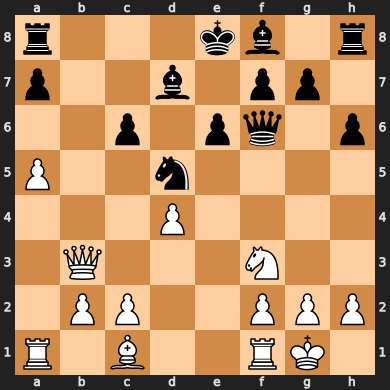

In [18]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_vector(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [19]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.44      0.27      0.34      6062
           1       0.23      0.22      0.22      7513
           2       0.34      0.28      0.31     15196
           3       0.65      0.81      0.72     53898
           4       0.24      0.14      0.18      7618
           5       0.24      0.09      0.14      5290
           6       0.44      0.32      0.37      4423

    accuracy                           0.54    100000
   macro avg       0.37      0.30      0.32    100000
weighted avg       0.50      0.54      0.51    100000



In [20]:
import json
import time

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = "experiments/logs"):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")


In [21]:
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = "experiments/logs"):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [22]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = "experiments/results"):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)

In [23]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "input_shape": 768,
    "output_shape": 7
}

dataset_paths = {
    "train": "./dataset_processed_clean_split/chess_state_bitboard_train.npz",
    "val":   "./dataset_processed_clean_split/chess_state_bitboard_val.npz",
    "test":  "./dataset_processed_clean_split/chess_state_bitboard_test.npz"
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/run_2025_12_28_giraffe_baseline_config.json
[Logs] Saved training history to experiments/logs/run_2025_12_28_giraffe_baseline_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        52.16%
[Results] Off-by-1 Acc:    79.33%
[Results] MAE:             0.8107
[Results] Latency:         0.0110 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 7019 samples
   - Off by 4: 927 samples
   - Off by 5: 648 samples
   - Off by 6: 436 samples
[Results] Saved all metrics to experiments/results
------------------------------------------------------------


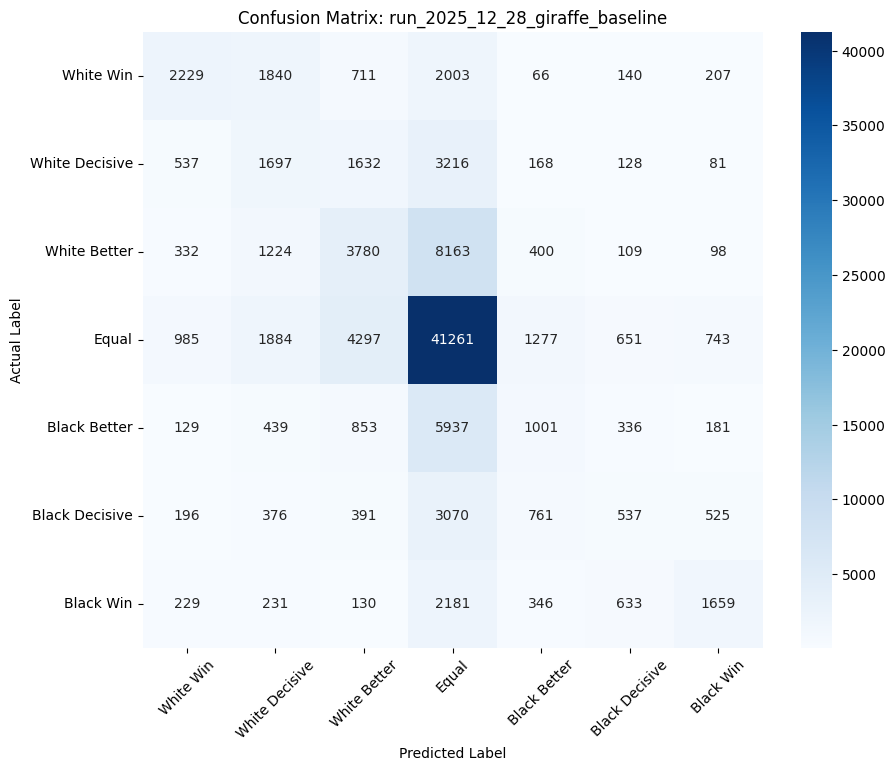

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(experiment_name: str, save_dir: str = "experiments/results"):
    matrix_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    try:
        cm = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Could not find matrix at {matrix_path}")
        return

    class_names = [
        "White Win", "White Decisive", "White Better", "Equal", 
        "Black Better", "Black Decisive", "Black Win"
    ]

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title(f"Confusion Matrix: {experiment_name}")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.show()

plot_confusion_matrix(RUN_ID)

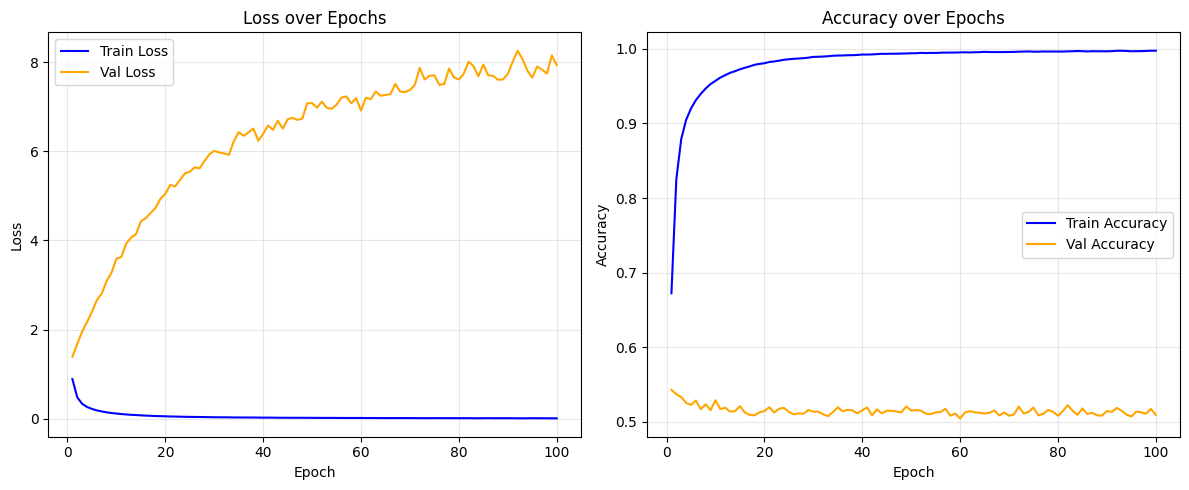

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path("./experiments/logs/run_2025_12_28_giraffe_baseline_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()